In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
# Formato para matplotlib
from matplotlib import rcParams
%matplotlib inline
%config InlineBackend.figure_format='retina'
rcParams['font.family'] = 'serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['figure.dpi'] = 120
rcParams['legend.fontsize'] = 10
rcParams['axes.labelsize'] = 'large'
rcParams['axes.xmargin'] = 0
rcParams['axes.grid'] = True

config_code_dict = {
    "a": {"fotomultiplicador": False, "laser power": False, "laser light": False},
    "b": {"fotomultiplicador": True, "laser power": False, "laser light": False},
    "c": {"fotomultiplicador": True, "laser power": True, "laser light": False},
    "d": {"fotomultiplicador": True, "laser power": True, "laser light": True},
}

# Una Señal

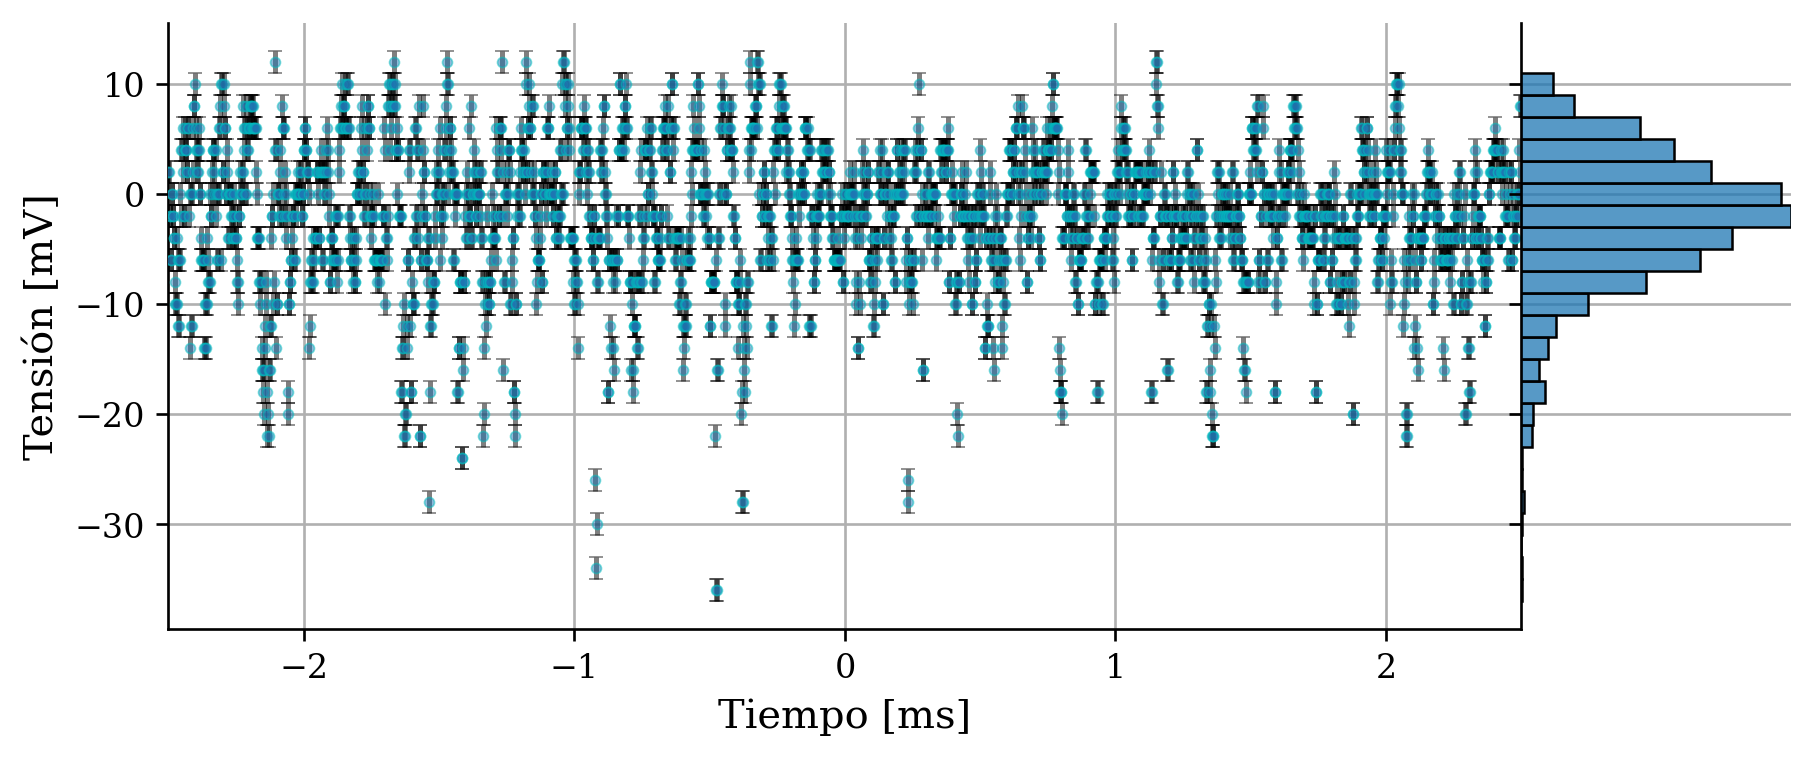

In [2]:
# Leer una tanda guardada:
config = "d"  # Estado del instrumental al medir
tension = 990  # Tensión en la fuente del fotomultiplicador
angulo = 230  # Ángulo relativo entre polarizadores a la salida del láser
modo = "fpeaks"  # Modo del osciloscopio: "fpeaks" para find peaks y "sample" para sampleo
tiempo, channel1 = np.load(f"barrido/{modo}_a{angulo}_t{tension}_{config}.npy")  # s, V
# Ploteando solo una medición a la vez:
med_index = 9
tiempo = tiempo[med_index*2500:(med_index + 1)*2500]
channel1 = channel1[med_index*2500:(med_index + 1)*2500]

res = 2e-3  # V
vals_unicos = np.unique(channel1)
bins = 1e3*np.arange(vals_unicos.min() - res/2, vals_unicos.max()+res/2, res)  # mV
g = sns.JointGrid(x=tiempo*1e3, y=channel1*1e3, height=4, ratio=5, space=0)
# g.plot_joint(plt.errorbar, xerr=np.diff(tiempo).mean(),
#              fmt='.', ms=2, mec="k", mew=0.5, alpha=0.5, ecolor='k', capsize=2, zorder=10)
g.plot_joint(plt.errorbar, yerr=1e3*res/2,
             fmt=".", ms=6, mec="c", mew=0.5,
             ecolor="k", capsize=2, alpha=0.5, zorder=10)
g.ax_marg_x.set_visible(False)
g.plot_marginals(sns.histplot, bins=bins, zorder=10)
g.ax_joint.set_xlabel("Tiempo [ms]")
g.ax_joint.set_ylabel("Tensión [mV]")
g.ax_joint.set_xlim(min(tiempo*1e3), max(tiempo*1e3))
g.figure.set_size_inches((8, 3.5))
plt.show()

# Distribución de Tensión

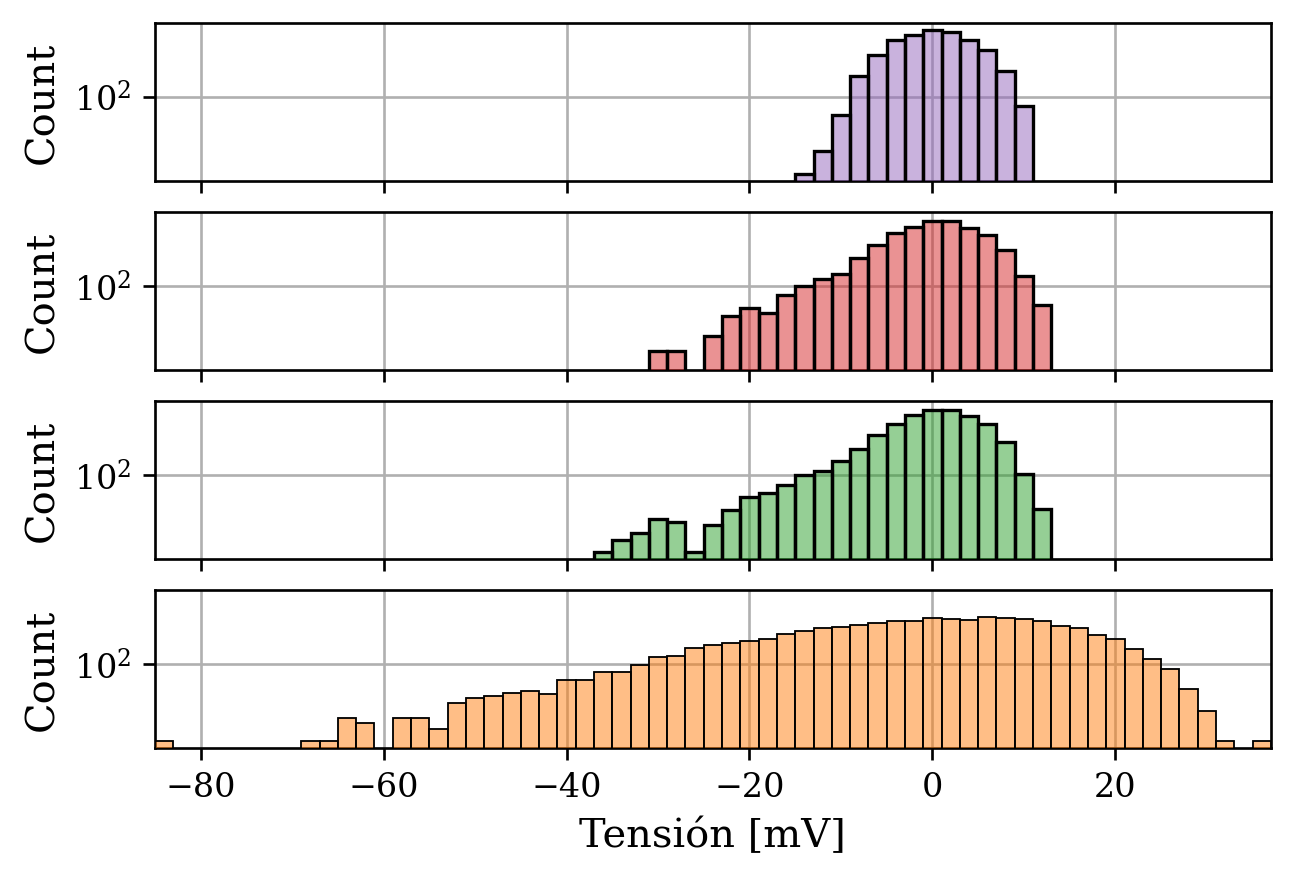

In [60]:
modo = "fpeaks"
angulo = 230
fig, axs = plt.subplots(4, 1, sharex=True, sharey=True)
color_id = 4
for config, tension, ax in zip(["a", "b", "c", "d"], [0, 990, 990, 990], axs):
    tiempo, channel1 = np.load(f"osci_fpeaks/{modo}_a{angulo}_t{tension}_{config}.npy")  # s, V
    res = 2e-3  # Escala en 50 mV
    # res = 4e-3  # Escala en 100 mV
    vals_unicos = np.unique(channel1)
    bins = np.arange(vals_unicos.min() - res/2, vals_unicos.max()+res/2, res)  # V
    sns.histplot(x=channel1*1e3, color=f"C{color_id}", bins=bins*1e3, zorder=10, edgecolor="k",
                    alpha=0.5, label=config + " Sample", ax=ax)
    color_id -= 1
    ax.set_yscale("log")
# ax.set_yticks([1e0, 10**1.5, 1e3])
ax.set_xlabel("Tensión [mV]")
plt.show()

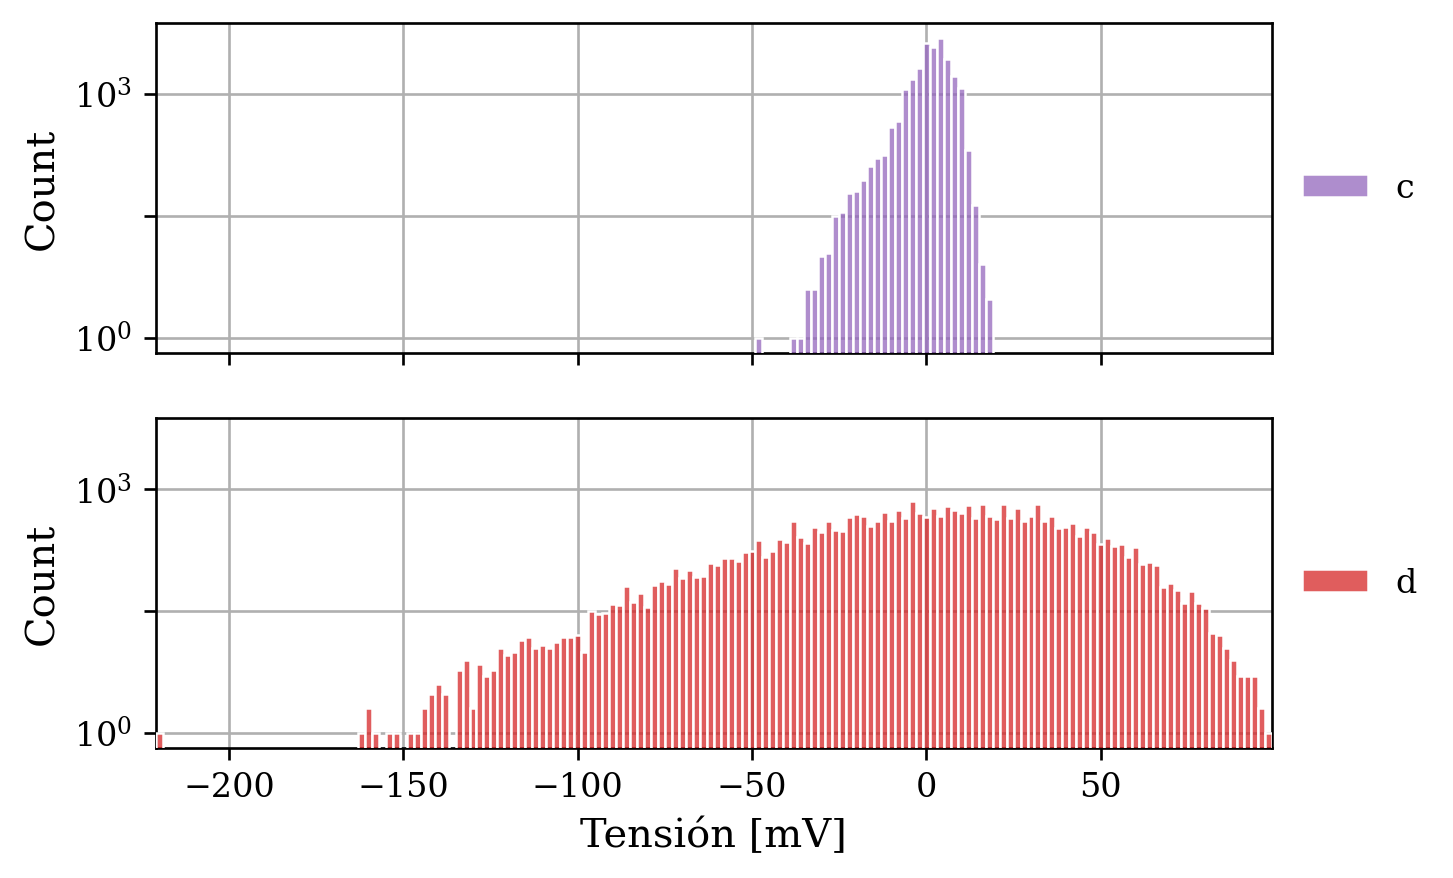

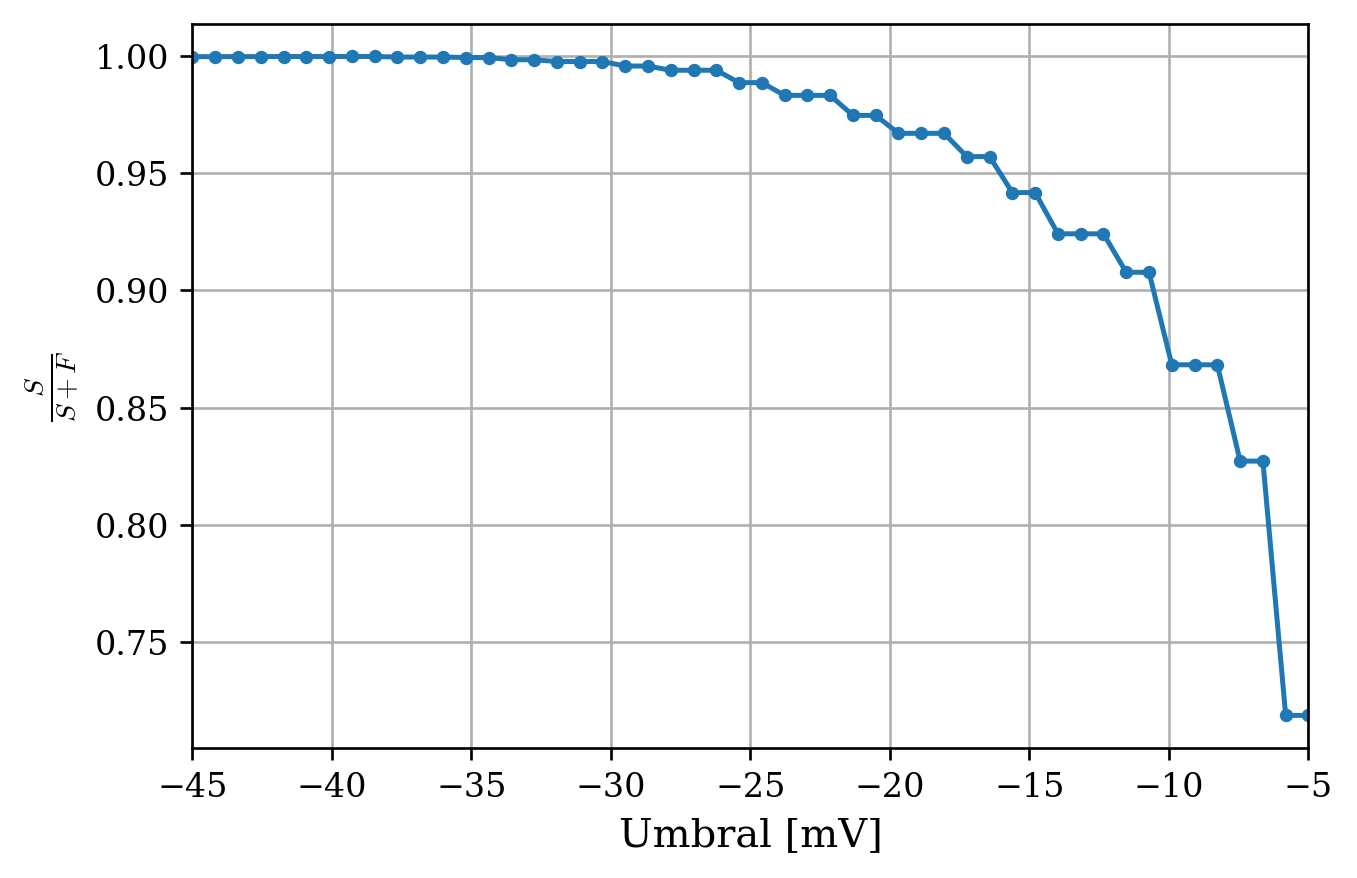

In [52]:
### REVISAR LECTURA DE DATOS: VER ARRIBA PARA EJEMPLOS
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)
tension_dist = dict()
t_fuente = 1050  # V
angulo_pol = 240  # °
j = 0
for config, ax in zip(["c", "d"], axs):
    tiempo = np.zeros(10*2500)
    channel1 = np.zeros_like(tiempo)
    res = 2e-3  # V
    
    for i in range(10):
        tiempo[i*2500:(i+1)*2500], channel1[i*2500:(i+1)*2500] = np.load(f"barrido/angulo_{config}{angulo_pol}{i}.npy")  # s, V
    vals_unicos = np.unique(channel1)
    bins = np.arange(vals_unicos.min() - res/2, vals_unicos.max()+res/2, res)  # V
    sns.histplot(x=channel1*1e3, color=f"C{4-j}", bins=bins*1e3, zorder=10, edgecolor="w",
                 #element="step", fill=False,
                 alpha=0.75, lw=0.75,
                 label=config, ax=ax)
    tension_dist[config] = channel1
    j += 1
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), frameon=False)
ax.set_yscale("log")
ax.set_yticks([1e0, 10**1.5, 1e3])
ax.set_xlabel("Tensión [mV]")
plt.show()

umbrales = np.linspace(-45e-3, -5e-3, )
frac = np.zeros_like(umbrales)
for i, umbral in enumerate(umbrales):  # V
    positivos_d = sum(tension_dist["d"] <  umbral)
    positivos_c = sum(tension_dist["c"] <  umbral)
    frac[i] = (positivos_d-positivos_c)/(positivos_d)

plt.plot(umbrales*1e3, frac, '.-')
plt.xlabel("Umbral [mV]")
plt.ylabel(r"$\frac{S}{S+F}$")
plt.show()

# Análisis Picos

### Sample

#### Reviso qué parámetros establezco para buscar los picos para que el análisis sea correcto

Modo c, Tensión 930


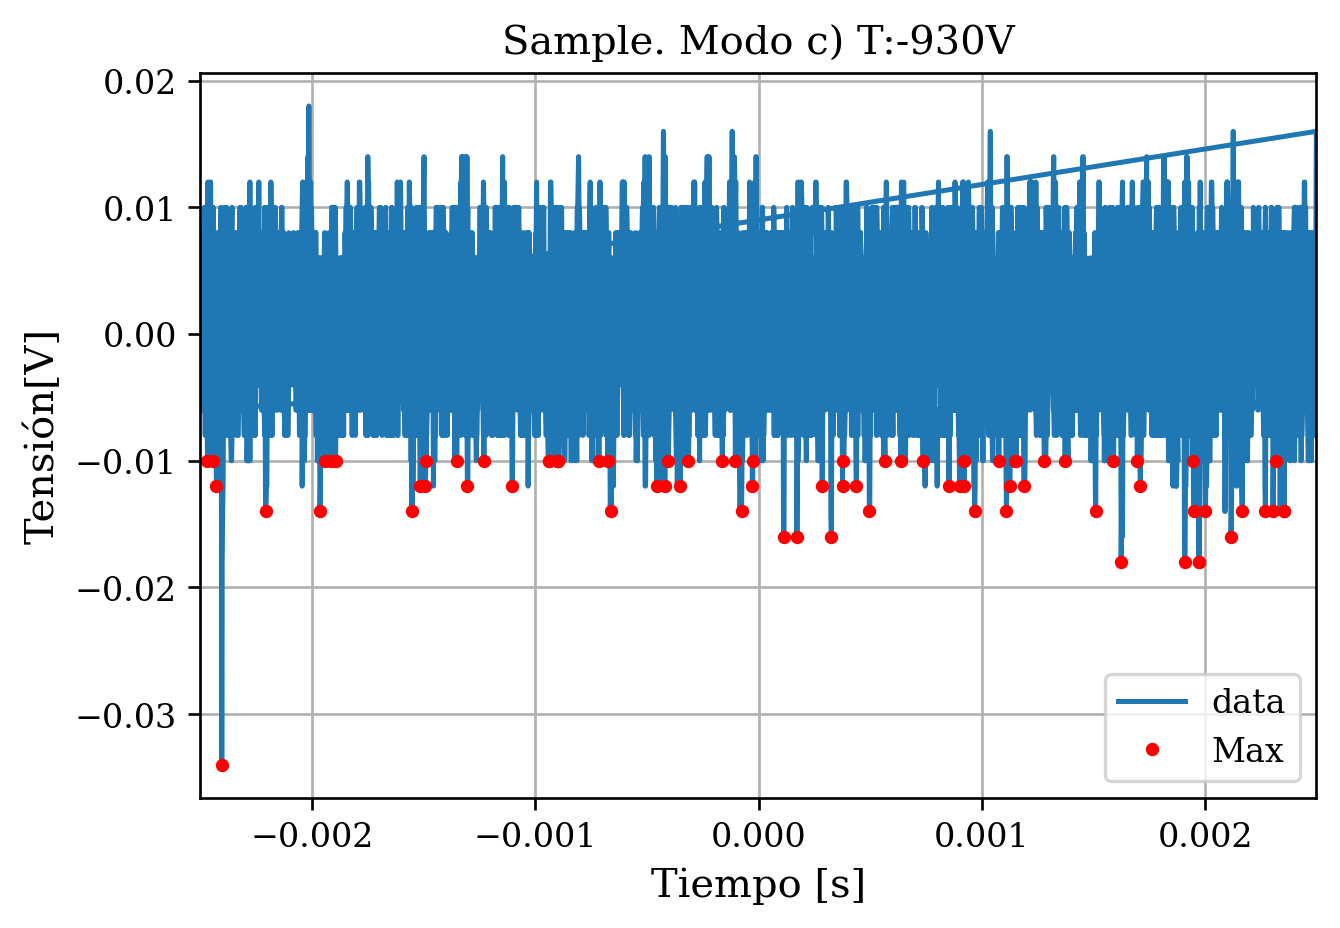

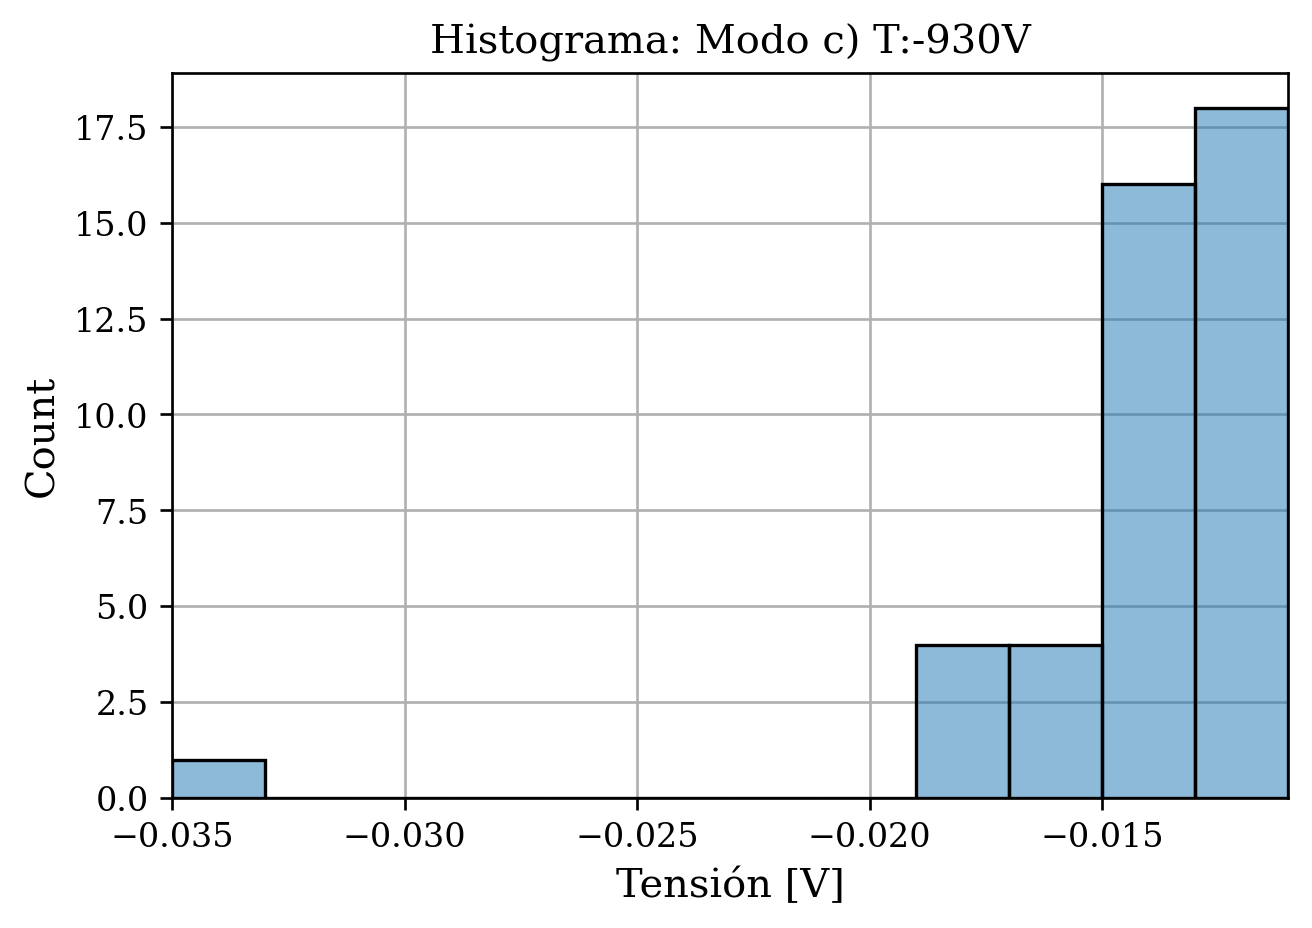

Se encontraron 77 picos.

Modo d, Tensión 930


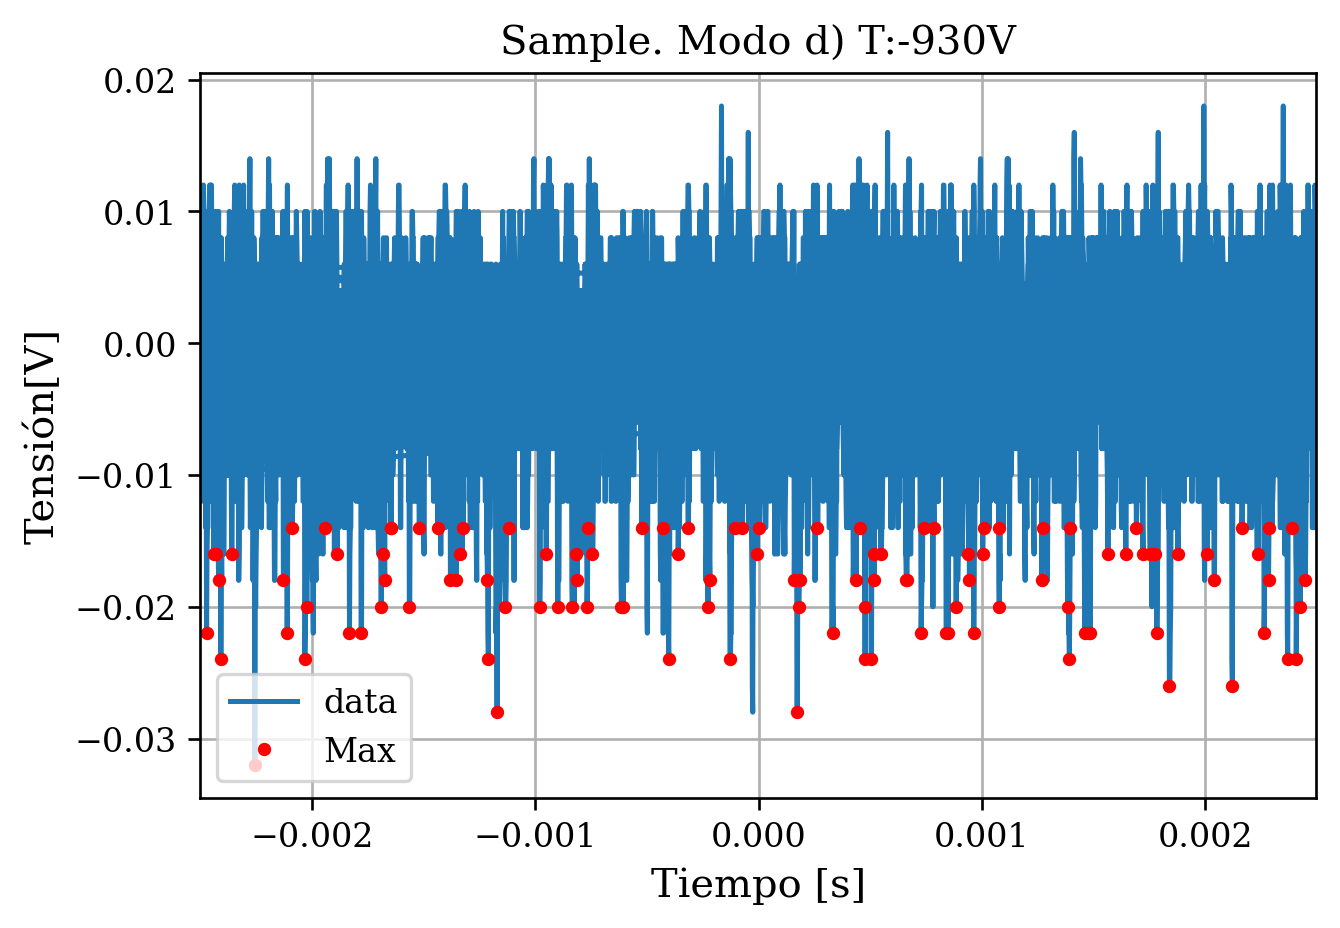

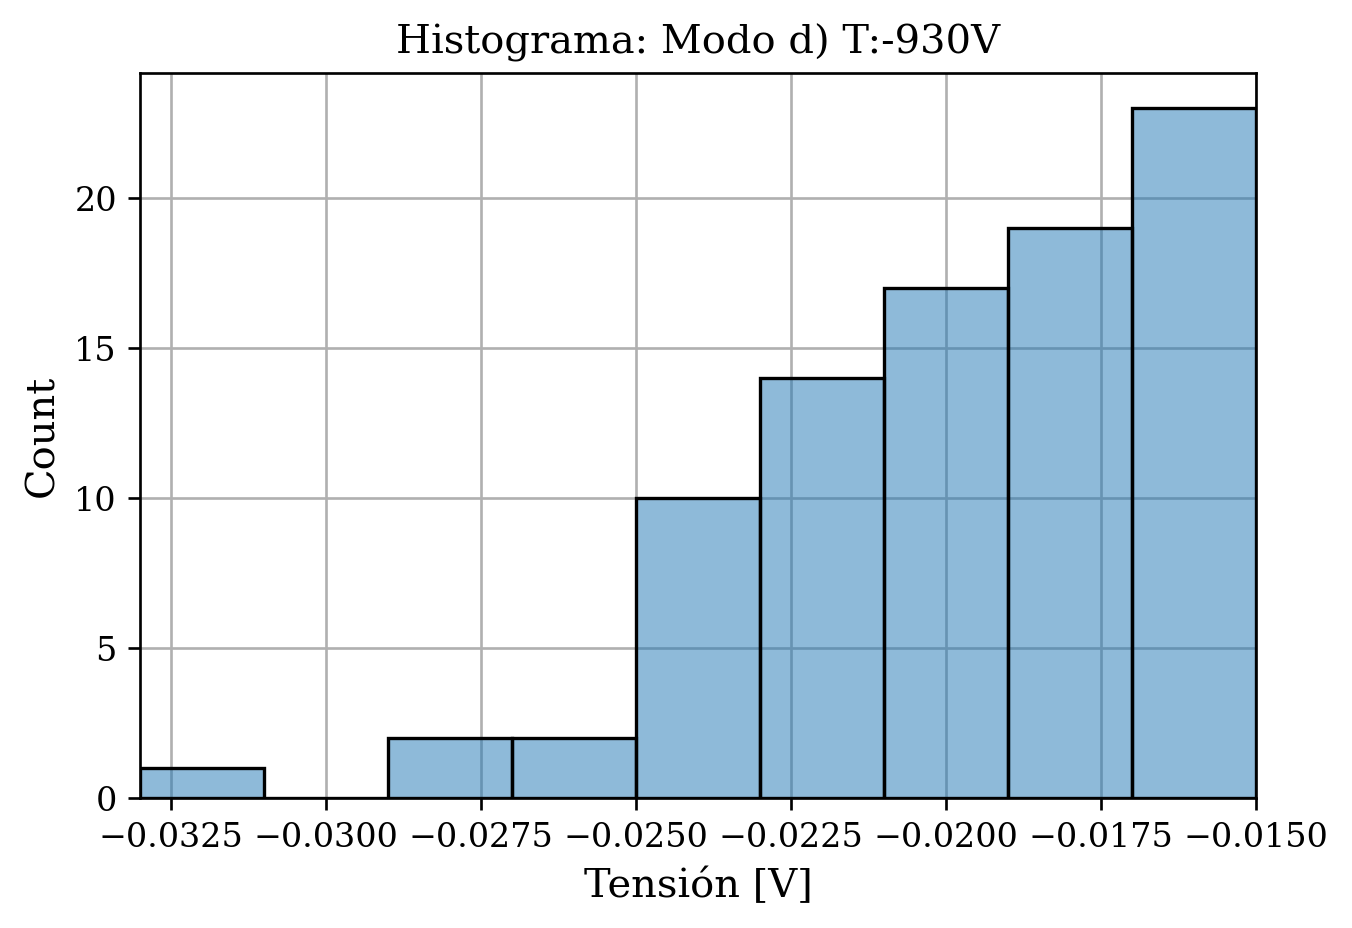

Se encontraron 115 picos.

Modo c, Tensión 990


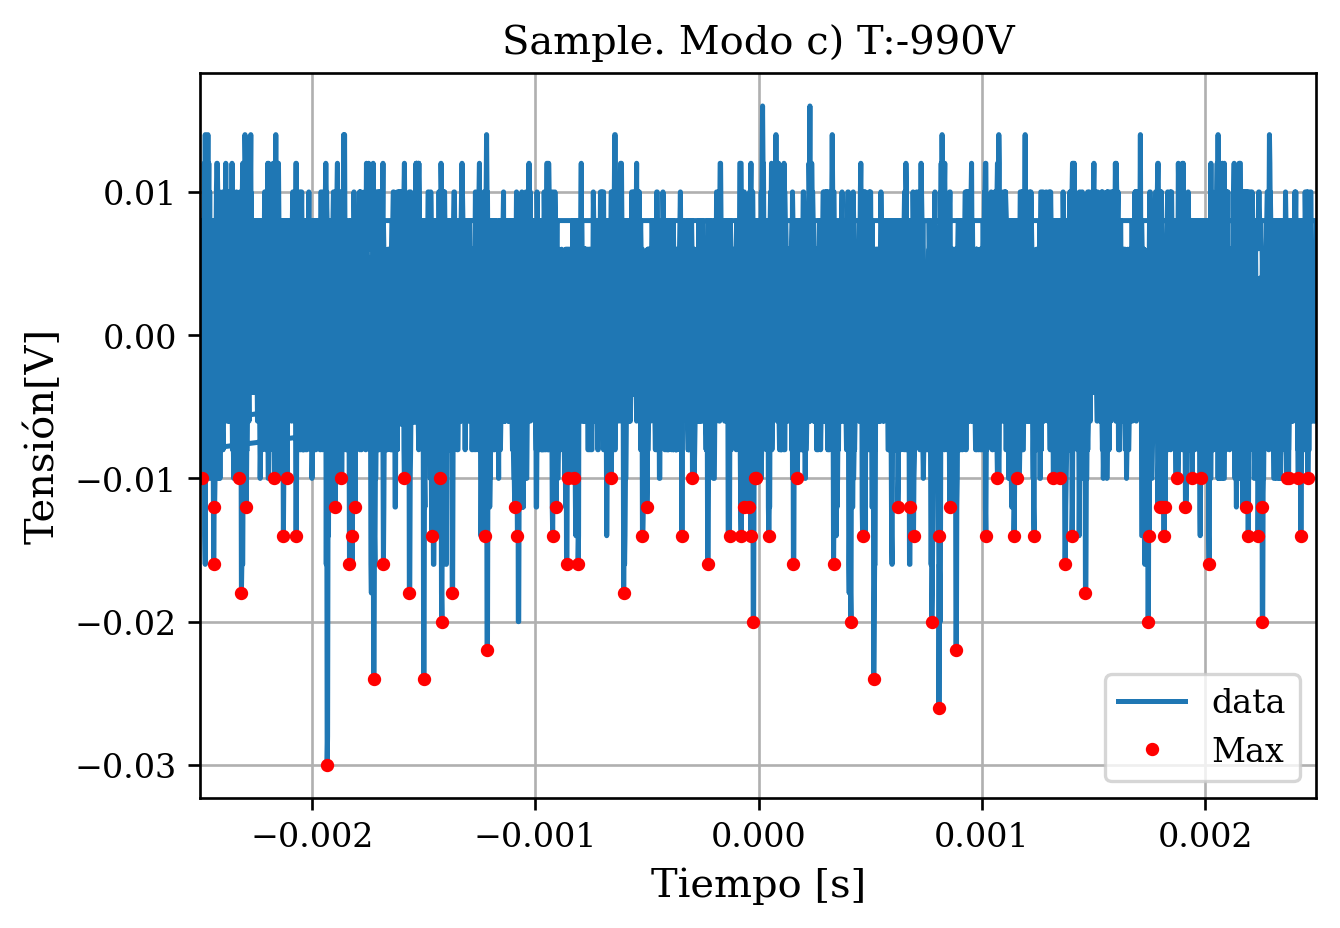

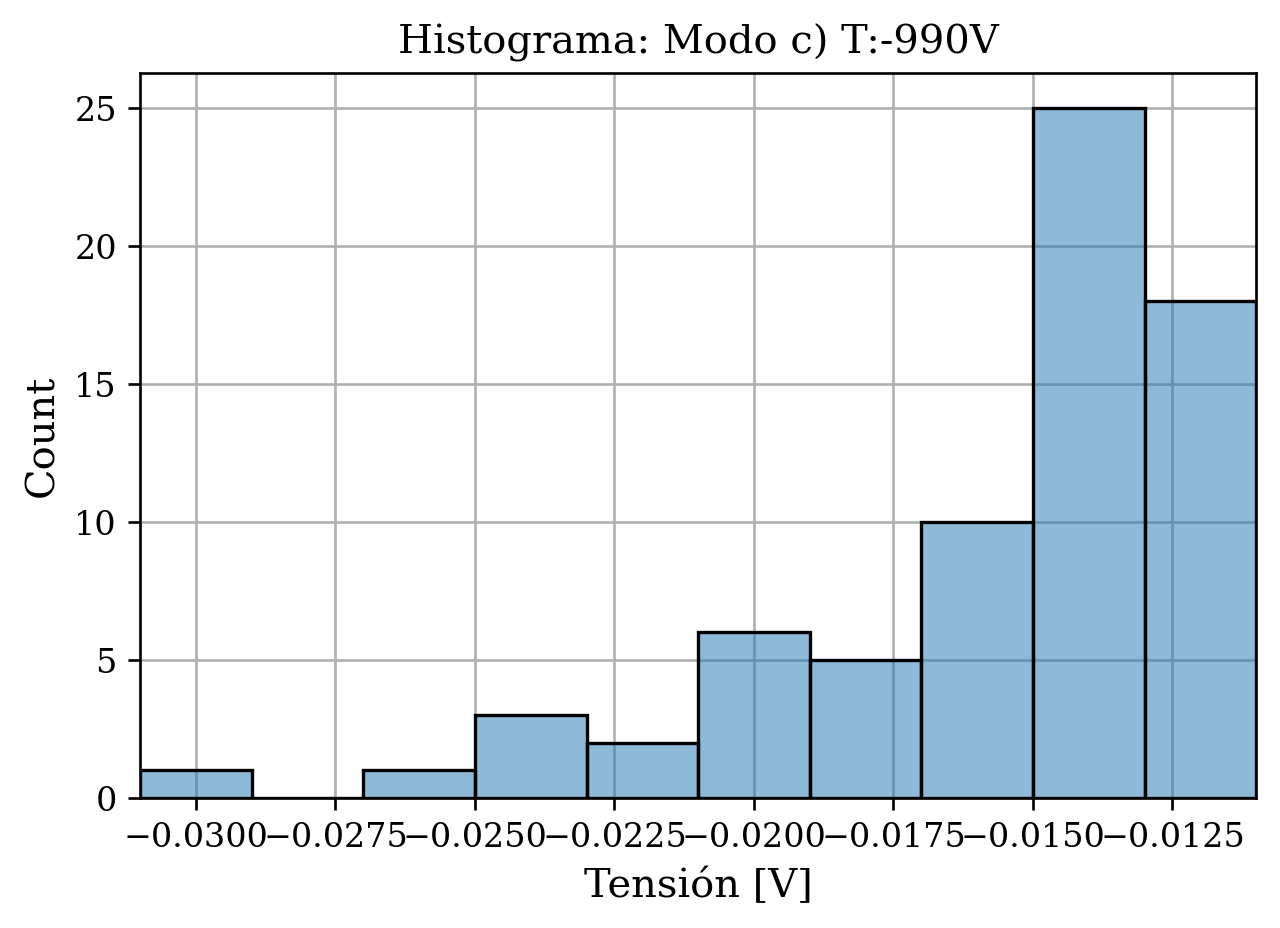

Se encontraron 96 picos.

Modo d, Tensión 990


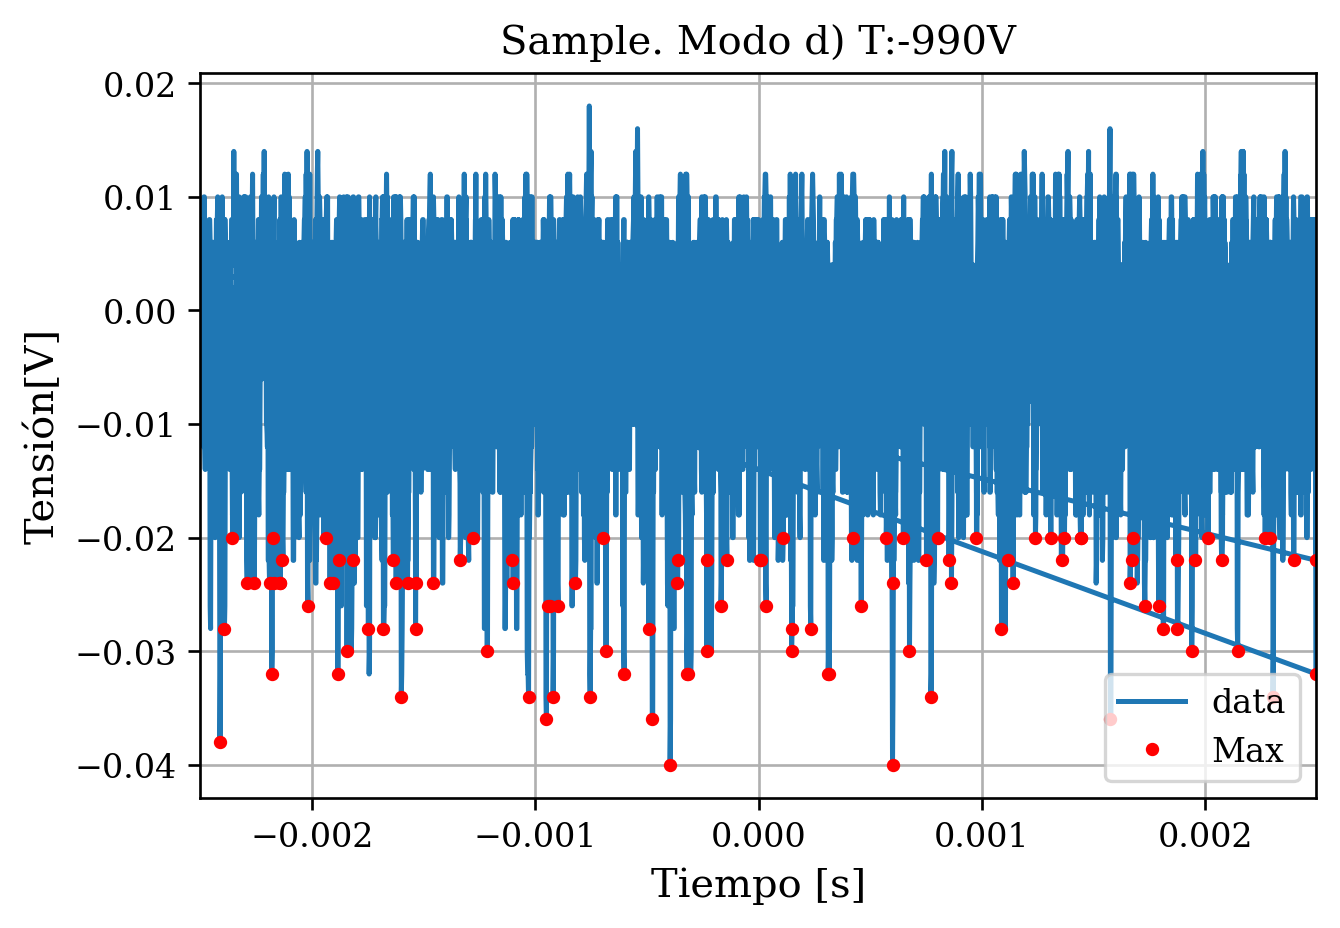

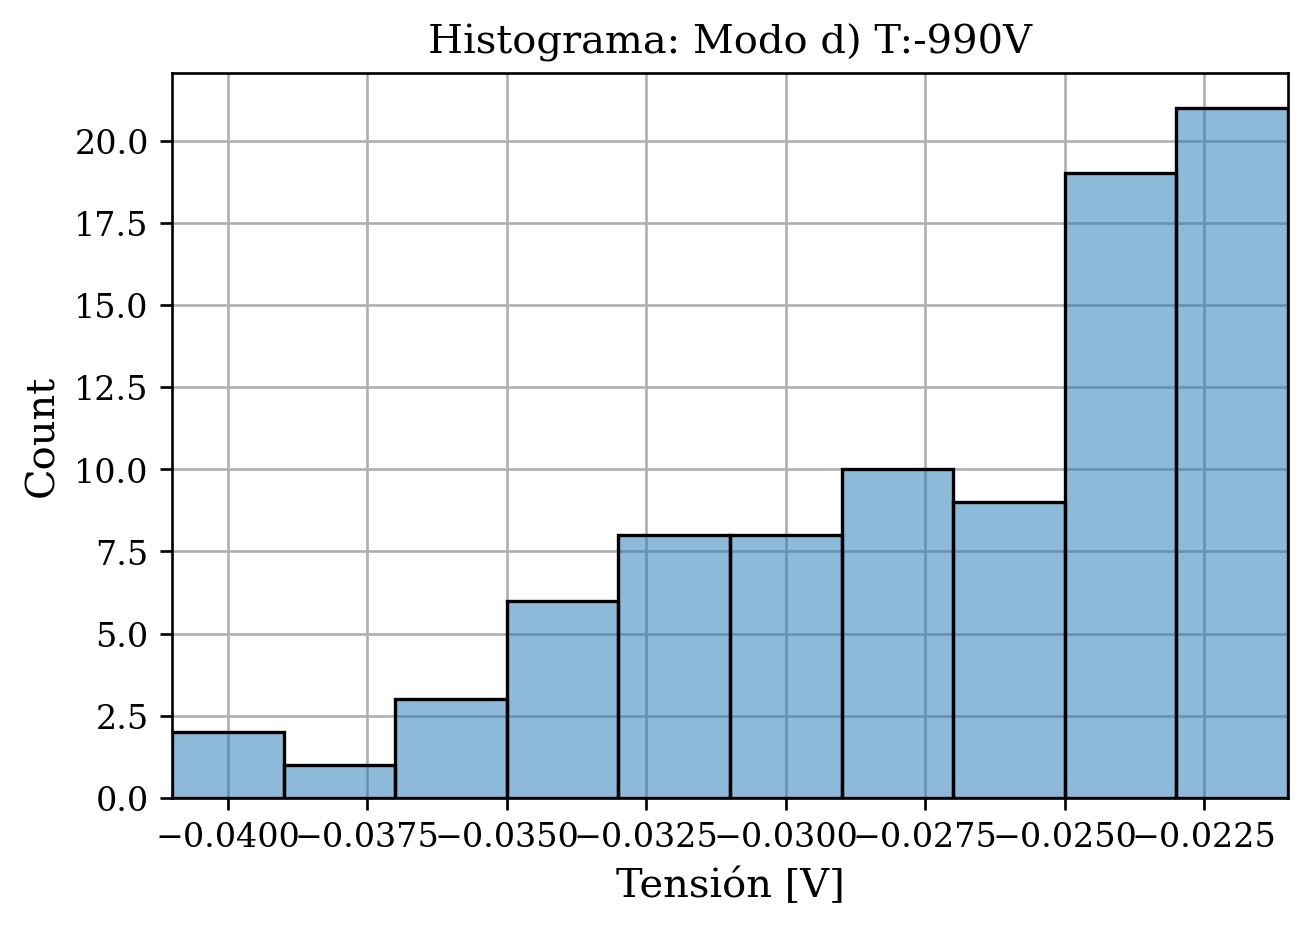

Se encontraron 107 picos.

Modo c, Tensión 1050


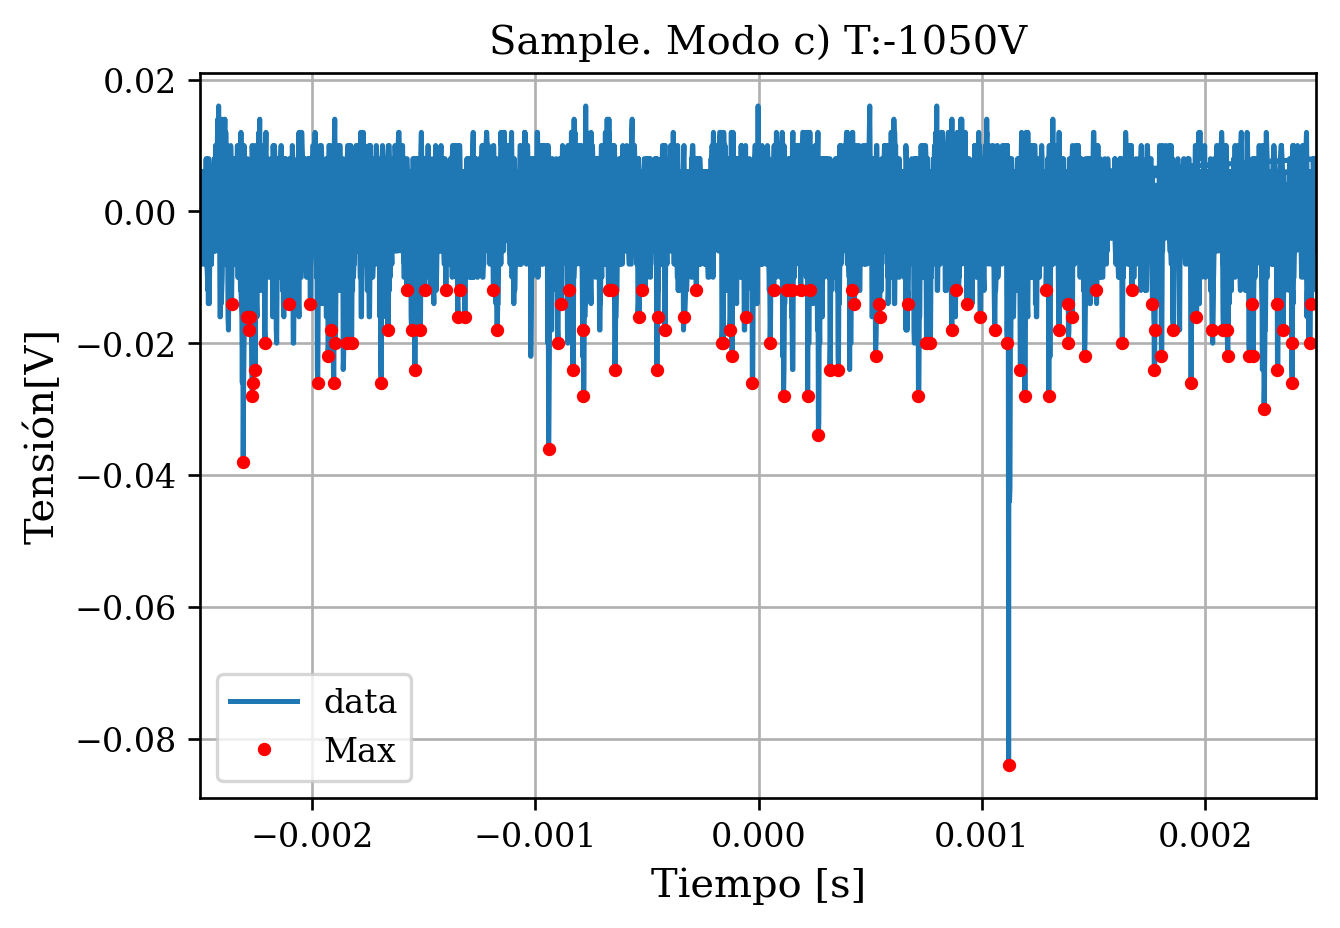

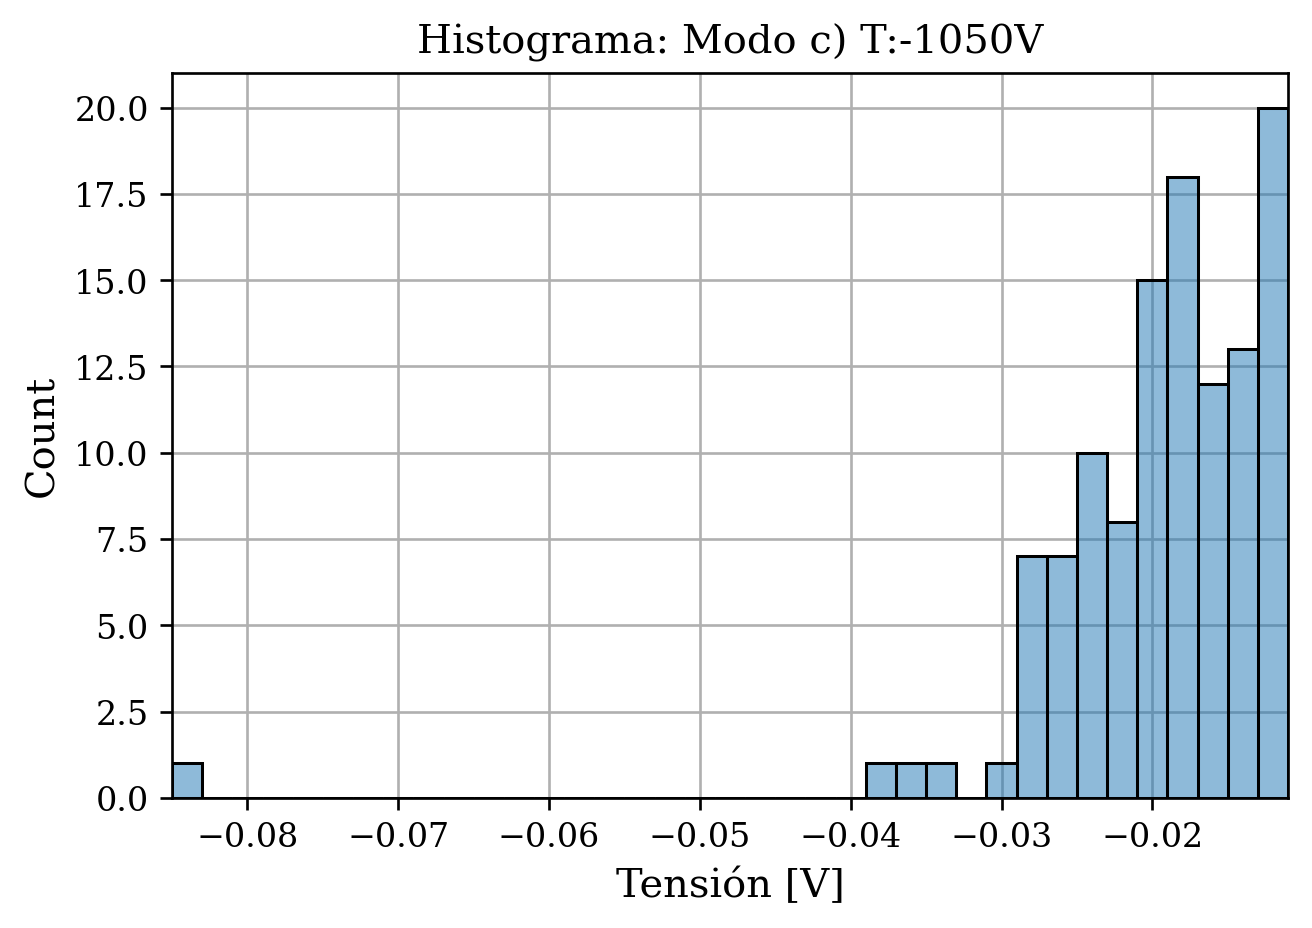

Se encontraron 115 picos.

Modo d, Tensión 1050


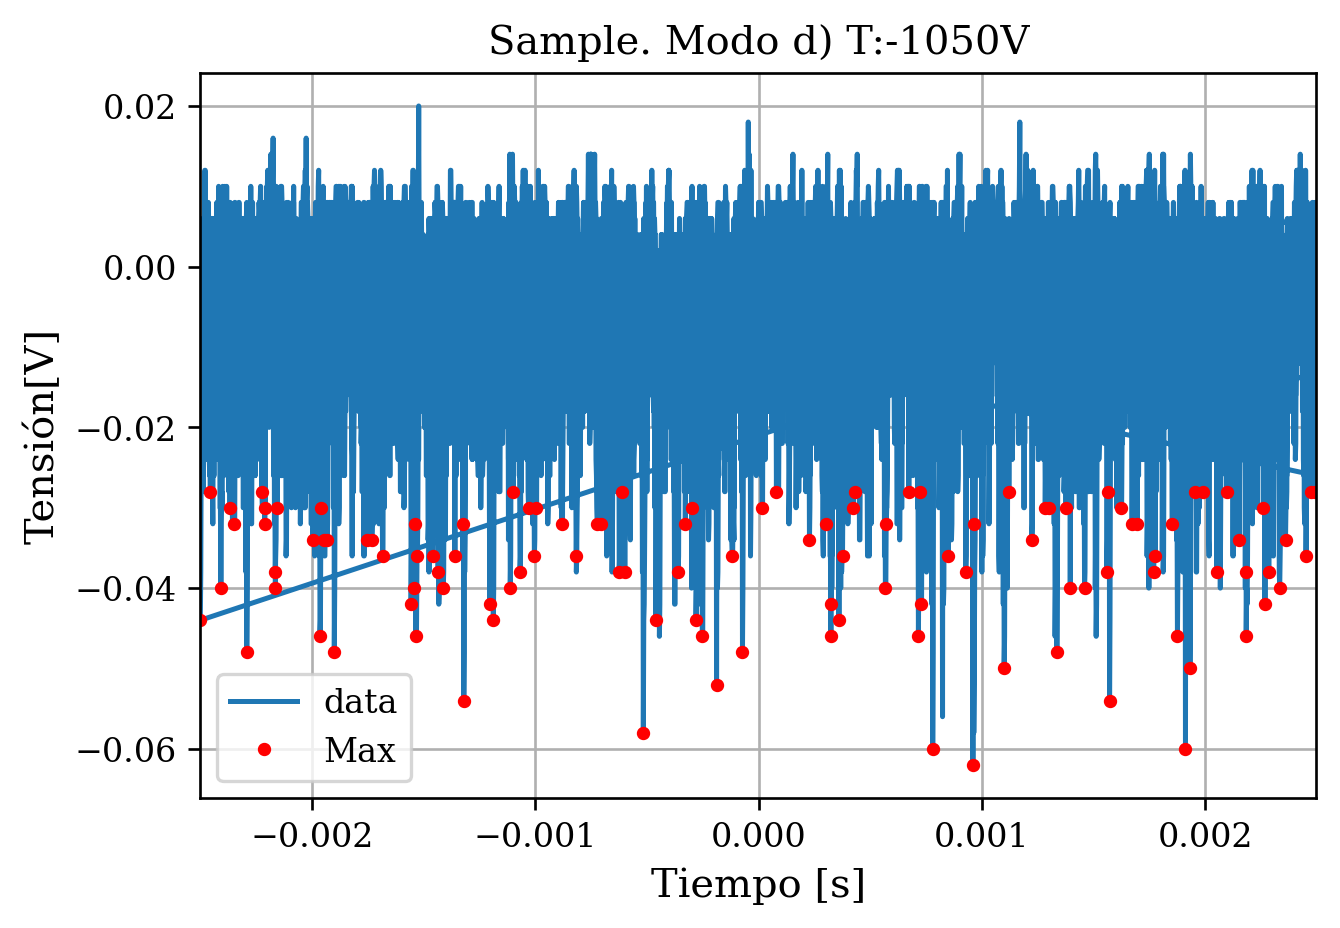

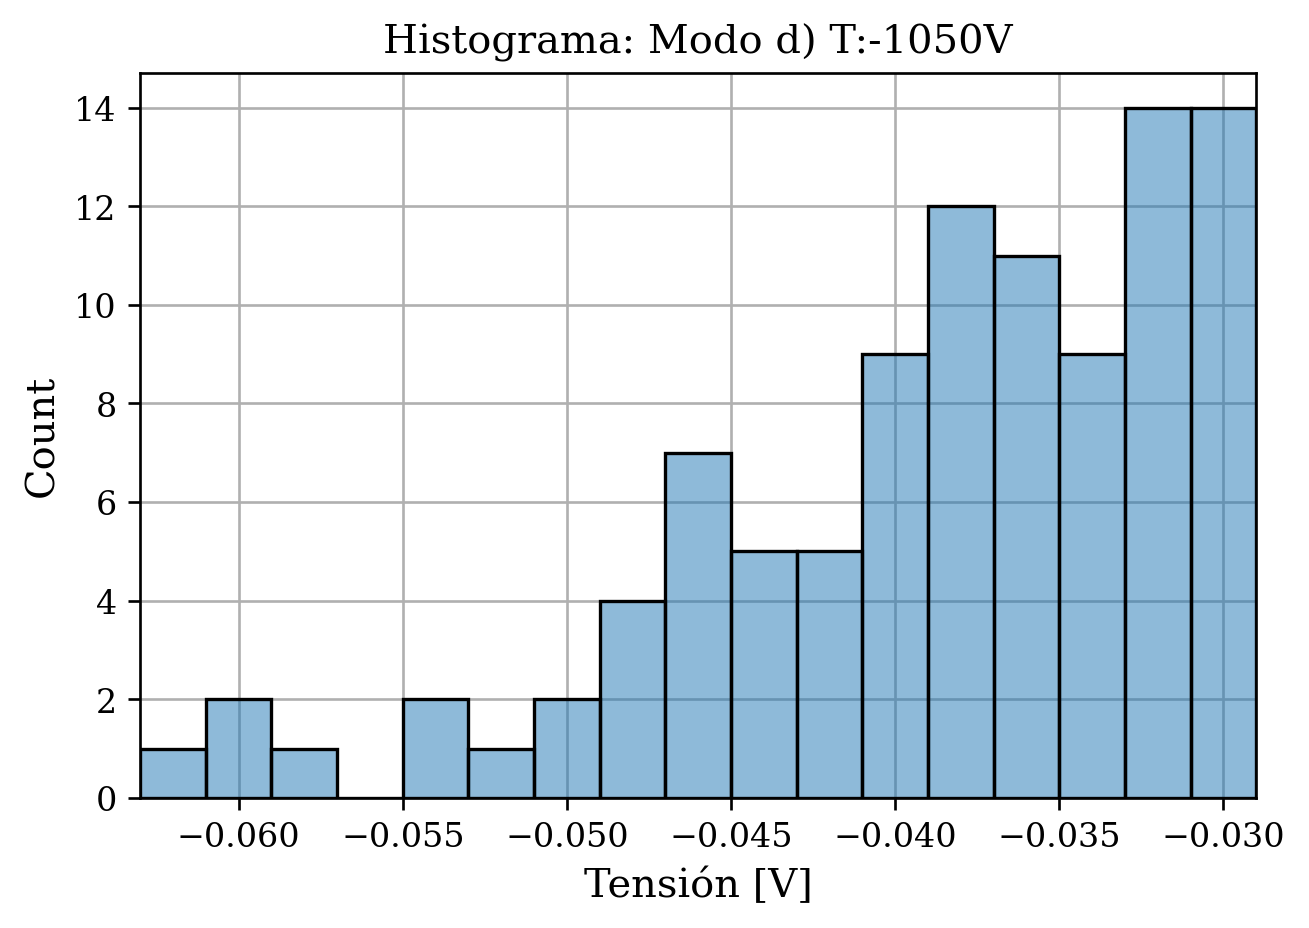

Se encontraron 114 picos.



In [126]:
#Establezco dos criterios para tomar picos

angulo = 230

for tension in ([930, 990, 1050]):
    for config in (["c", "d"]):
        print(f'Modo {config}, Tensión {tension}')
        tiempo, channel1 = np.load(f"barrido/fpeaks_a{angulo}_t{tension}_{config}.npy")  

    #Criterio 1
     #   if (tension>=990) & (config=="d"):
     #       max = find_peaks(-channel1, height=0.025, distance=150)[0] 
     #   elif (tension>=990) & (config=="c"):
     #       max = find_peaks(-channel1, height=0.015, distance=250)[0] 
     #   else:
     #       max = find_peaks(-channel1, height=0.013, distance=150)[0] 

    #Criterio 2: ver que tengan la misma cantidad de puntos contemplados
        height = np.linspace(0.008, 0.030,2000)

        for i in range(len(height)):
            max = find_peaks(-channel1, height=height[i], distance=100)[0]
            if 70<len(max)<120:
                break

        plt.title(f'Sample. Modo {config}) T:-{tension}V')
        plt.plot(tiempo, channel1, label='data')
        plt.plot(tiempo[max], channel1[max], '.', color='red', label='Max')
        plt.ylabel('Tensión[V]')
        plt.xlabel('Tiempo [s]')
        plt.legend()
        plt.show()

        plt.title(f'Histograma: Modo {config}) T:-{tension}V')
        res = 2e-3  
        vals_unicos = np.unique(channel1[max])
        bins = np.arange(vals_unicos.min() - res/2, vals_unicos.max()+res/2, res)  
        sns.histplot(x=channel1[max], bins=bins,zorder=10, edgecolor="k",
                    alpha=0.5, label=config + " Sample")
        plt.xlabel("Tensión [V]")
        plt.show()
        print(f'Se encontraron {len(max)} picos.\n')

#### Grafico la comparación de los Histogramas en modo c y d para distintas tensiones

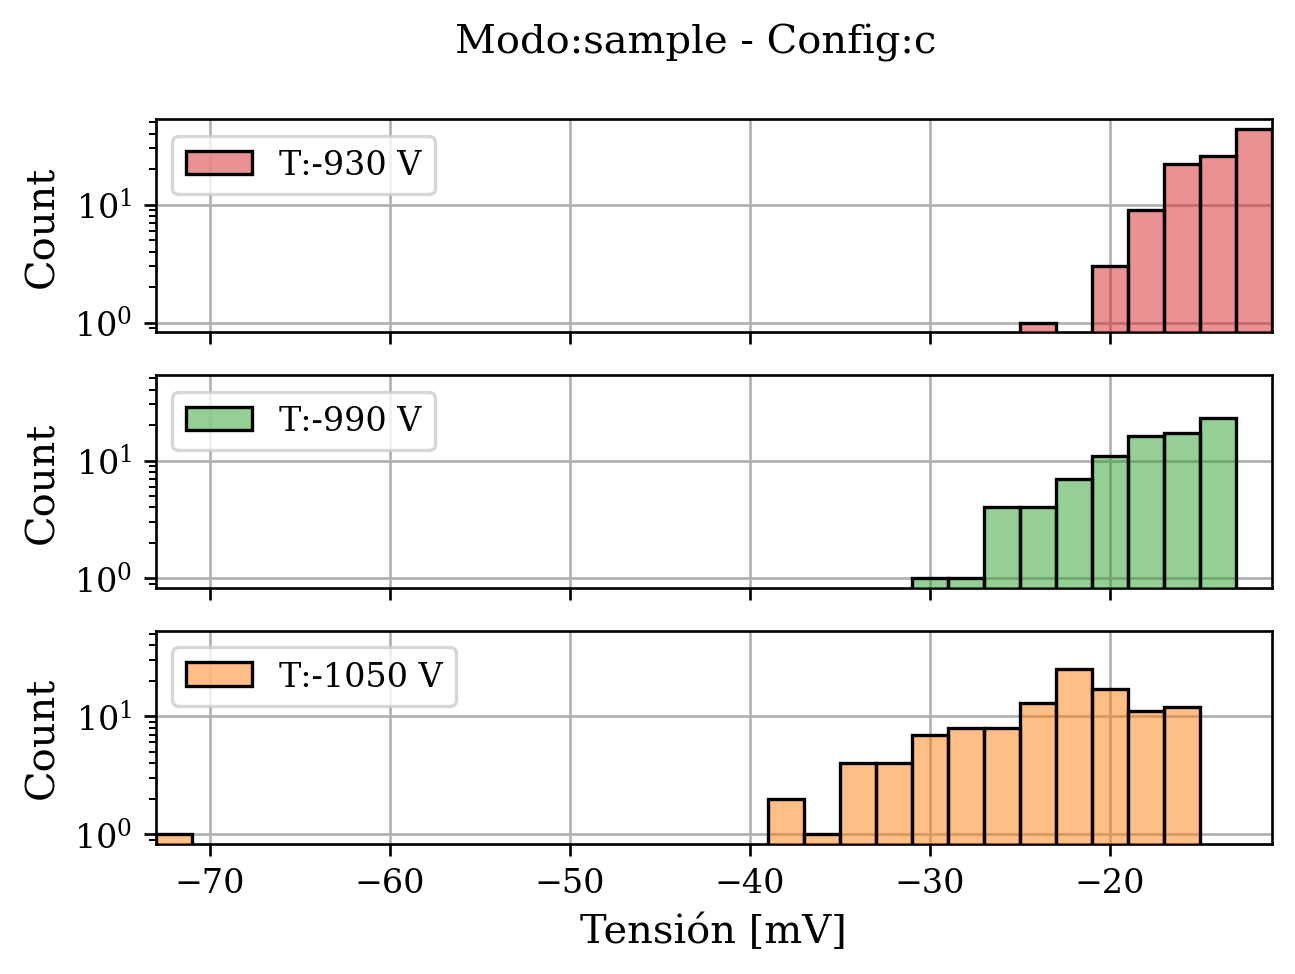

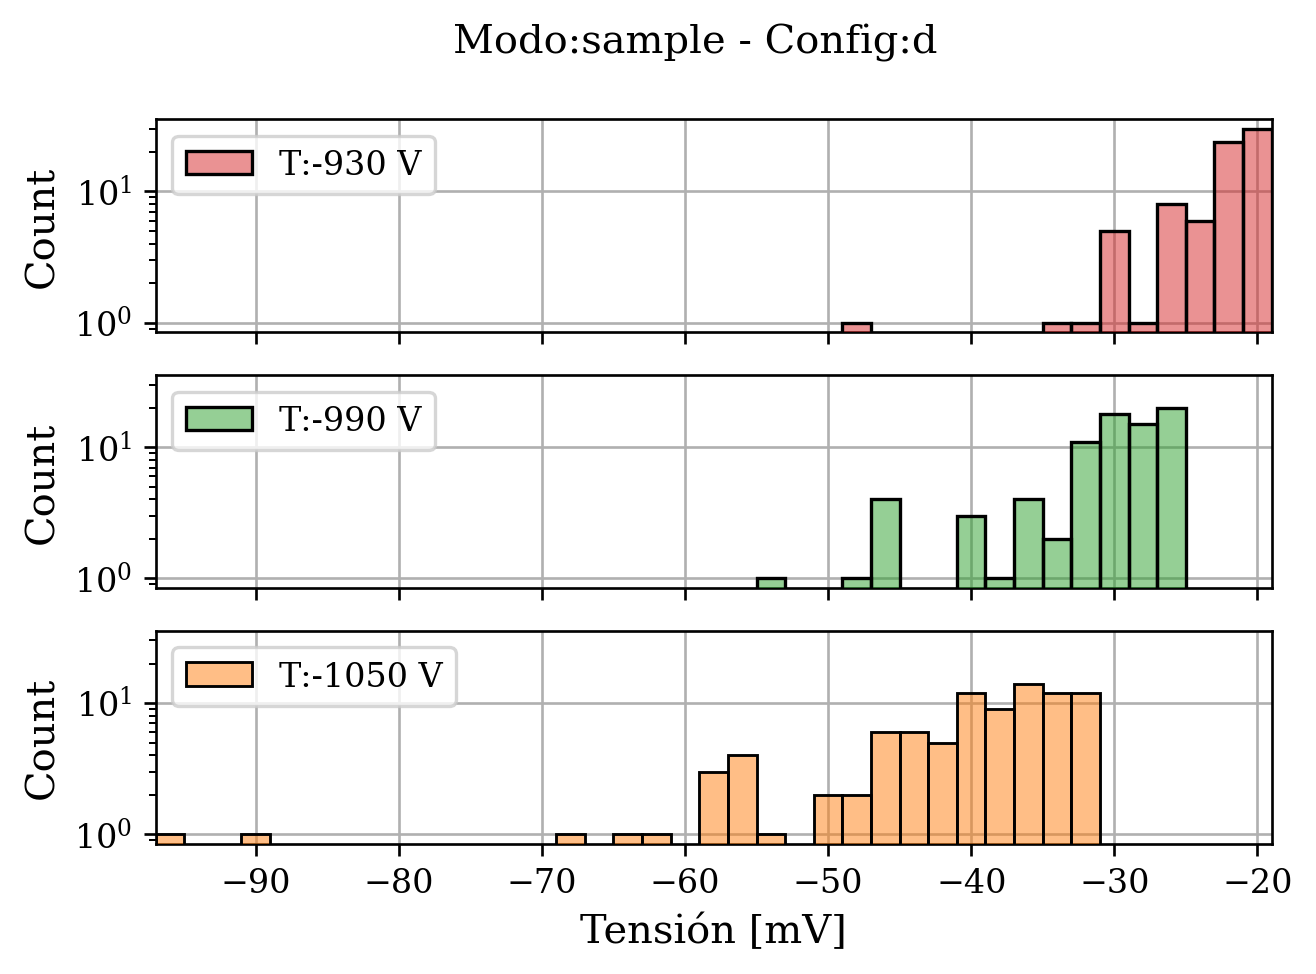

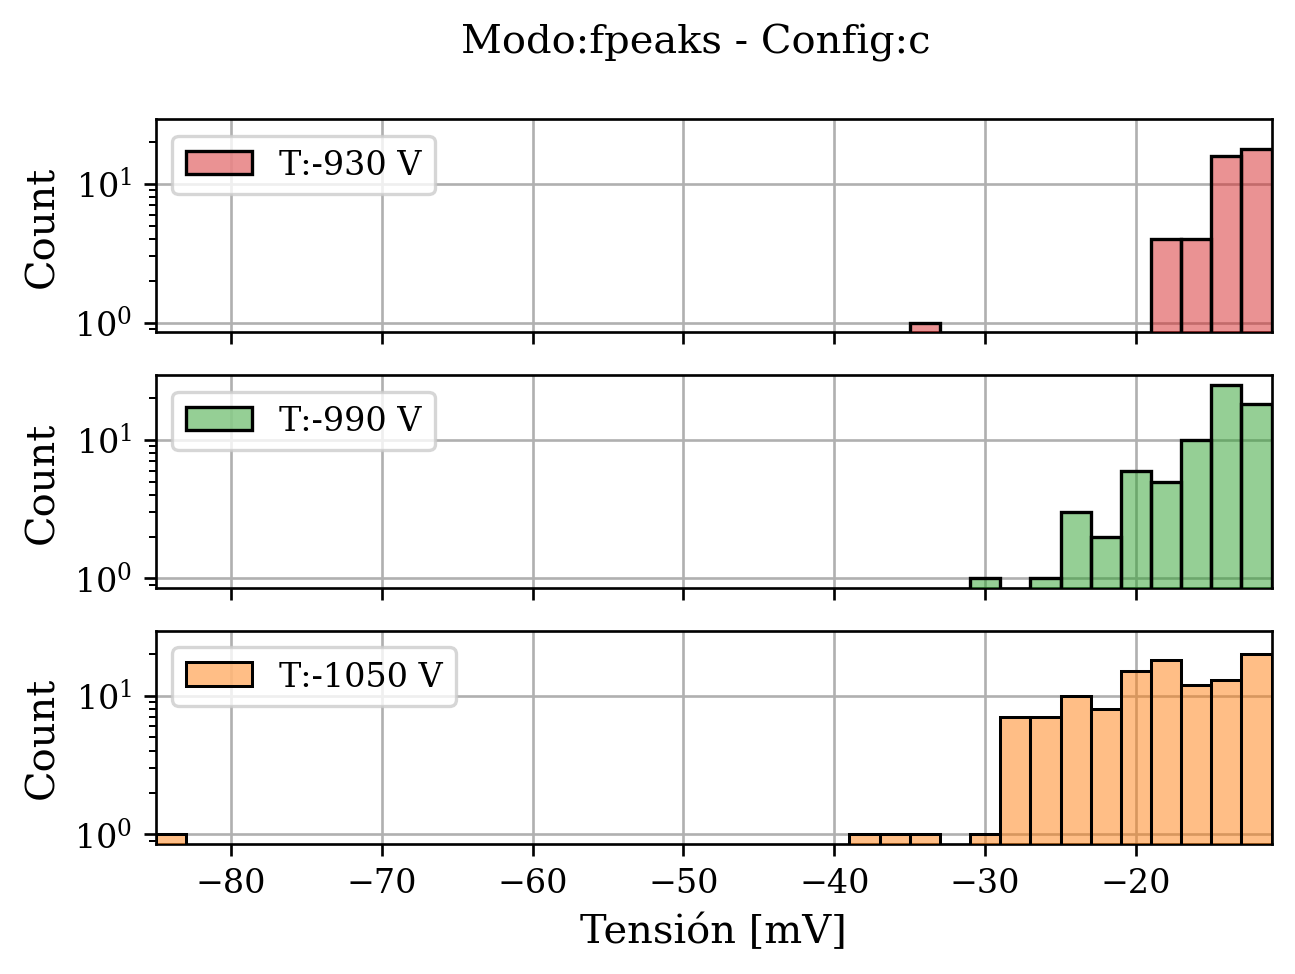

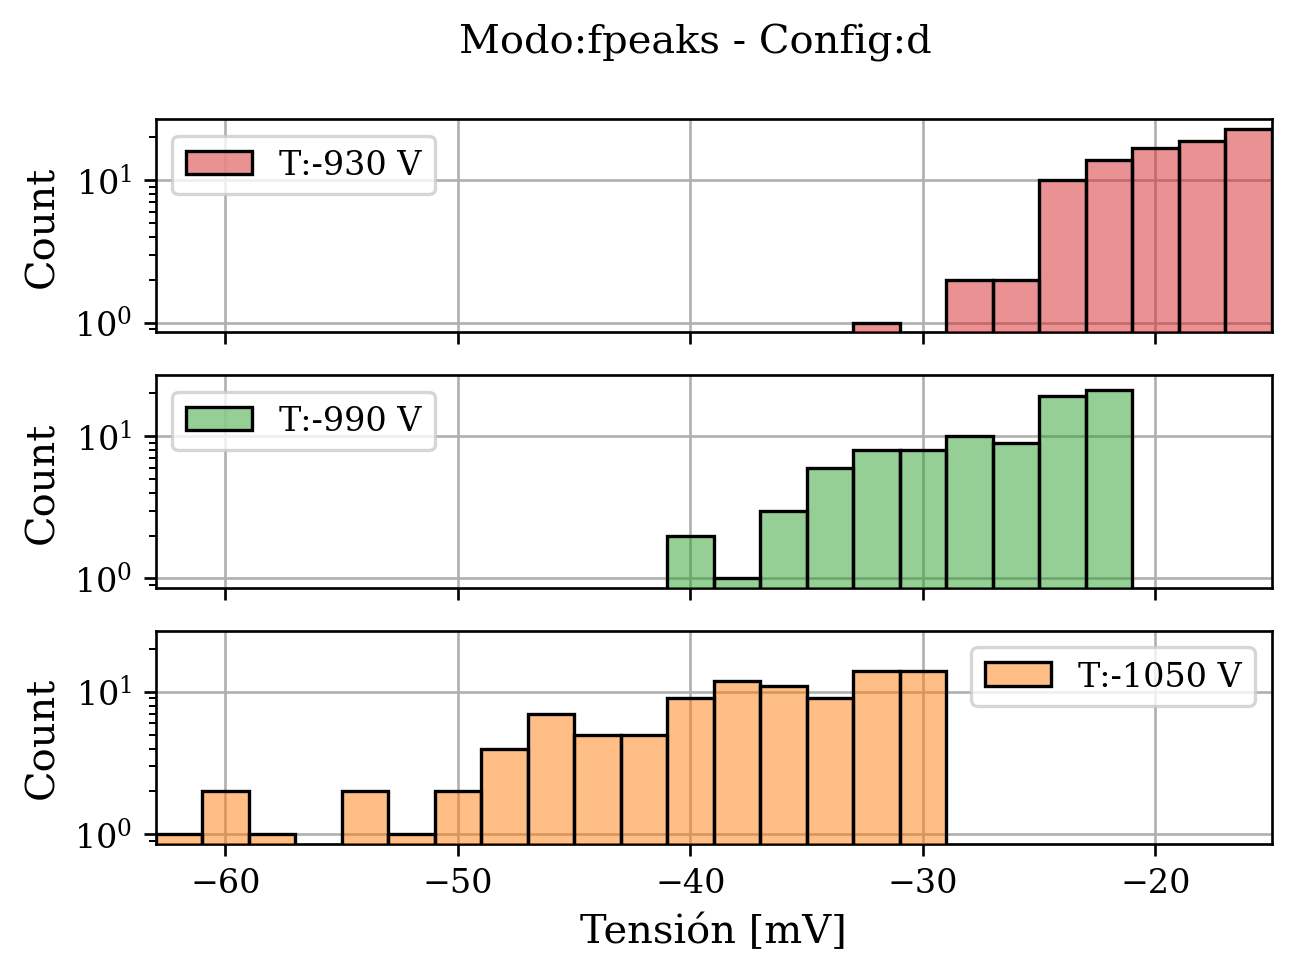

In [128]:
angulo = 230

for modo in (['sample', 'fpeaks']):
    for config in (['c', 'd']):    
        fig, axs = plt.subplots(3, 1, sharex=True, sharey=True)
        fig.suptitle(f'Modo:{modo} - Config:{config}')
        color_id = 3
        for tension, ax in zip([930, 990, 1050], axs):
            tiempo, channel1 = np.load(f"barrido/{modo}_a{angulo}_t{tension}_{config}.npy")  
            res = 2e-3  

            #Criterio 1

            #if (tension>=990) & (config=="d"):
            #    max = find_peaks(-channel1, height=0.025, distance=150)[0] 
            #elif (tension>=990) & (config=="c"):
            #    max = find_peaks(-channel1, height=0.015, distance=250)[0] 
            #else:
            #    max = find_peaks(-channel1, height=0.013, distance=150)[0] 

            #Criterio 2
            if modo == 'fpeaks':
                delta = 0.003
            else:
                delta = 0

            height = np.linspace(0.010 - delta, 0.030,2000)

            for i in range(len(height)):
                max = find_peaks(-channel1, height=height[i], distance=100)[0]
                if 70<len(max)<120:
                    break

            vals_unicos = np.unique(channel1[max])
            bins = np.arange(vals_unicos.min() - res/2, vals_unicos.max()+res/2, res)  
            sns.histplot(x=channel1[max]*1e3, color=f"C{color_id}", bins=bins*1e3, zorder=10, edgecolor="k",
                            alpha=0.5,  ax=ax, label = f'T:-{tension} V')
            color_id -= 1
            ax.set_yscale("log")
            ax.legend()
        ax.set_xlabel("Tensión [mV]")
    plt.show()